# Visualize Geneset Coverage

**Gregory Way, 2019**

Visualize the percent coverage of various geneset networks across different datasets.

Each compressed feature is assigned a single geneset based on the greatest enriched geneset by absolute value.
The ensemble models represent the aggregation of genesets across all five iterations per z dimension.
The "all" models represent each compression algorithm combined across all iterations per z dimension.

There are three sets of plots visualized for each coverage analysis.

1. Individual models by algorithm
2. Ensemble models by algorithm (note the difference in y axis)
  * The size of the point represents the relative strength of average enrichment
3. All models (note that coverage is on the right y axis)
  * The bars represent the number of unique genesets contributed by the specific algorithm

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))

In [2]:
# Set ggplot theme
coverage_theme <- theme_bw() + 
  theme(axis.text.x = element_text(angle = 90, size = 3.5),
        axis.text.y = element_text(size = 6),
        axis.title = element_text(size = 7),
        plot.title = element_text(hjust = 0.5, size = 8),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 8),
        legend.key.size = unit(1, "lines"))

algorithm_plot_labels <- c("pca" = "PCA",
                           "ica" = "ICA",
                           "nmf" = "NMF",
                           "dae" = "DAE",
                           "vae" = "VAE")
algorithm_colors <- c("#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00")
algorithms <- names(algorithm_plot_labels)

In [3]:
plot_info_list <- list(c("TCGA", "GpC5BP"),
                       c("TCGA", "GpC4CM"),
                       c("GTEX", "GpXCELL"))
plot_list <- list()

for (plot_info in plot_info_list) {
    dataset <- plot_info[1]
    metaedge <- plot_info[2]
    
    plot_identifier <- paste0(dataset, metaedge)
    plot_list[[plot_identifier]] <- list()

    # Setup file names
    base_file <- paste0(tolower(dataset), "_", tolower(metaedge), ".tsv")

    model_results <- file.path("results", paste0("model_results_", base_file))
    ensemble_results <- file.path("results", paste0("ensemble_results_", base_file))
    all_results <- file.path("results", paste0("all_results_", base_file))
    top_results <- file.path('results', paste0('top_results_', base_file, '.gz'))

    # Load data
    model_df <- readr::read_tsv(model_results,
                                col_types = readr::cols(
                                    .default = readr::col_integer(),
                                    algorithm = readr::col_character(),
                                    model_type = readr::col_character(),
                                    geneset_coverage = readr::col_double(),
                                    abs_top_z_score = readr::col_double(),
                                    dataset = readr::col_character(),
                                    geneset_name = readr::col_character()
                                ))

    model_df$algorithm <- factor(model_df$algorithm, levels = algorithms)
    model_df$z_dim <-
      factor(model_df$z_dim,
             levels = sort(as.numeric(paste(unique(model_df$z_dim)))))

    ensemble_df <- readr::read_tsv(ensemble_results,
                                   col_types = readr::cols(
                                       .default = readr::col_integer(),
                                       algorithm = readr::col_character(),
                                       model_type = readr::col_character(),
                                       geneset_coverage = readr::col_double(),
                                       abs_top_z_score = readr::col_double(),
                                       dataset = readr::col_character(),
                                       geneset_name = readr::col_character()
                                    ))

    ensemble_df$algorithm <- factor(ensemble_df$algorithm, levels = algorithms)
    ensemble_df$z_dim <-
      factor(ensemble_df$z_dim,
             levels = sort(as.numeric(paste(unique(ensemble_df$z_dim)))))

    ensemble_df$abs_top_z_score[is.infinite(ensemble_df$abs_top_z_score)] <-
        max(ensemble_df$abs_top_z_score[is.finite(ensemble_df$abs_top_z_score)])
    
    all_df <- readr::read_tsv(all_results,
                              col_types = readr::cols(
                                  .default = readr::col_integer(),
                                  model_type = readr::col_character(),
                                  geneset_coverage = readr::col_double(),
                                  abs_top_z_score = readr::col_double(),
                                  dataset = readr::col_character(),
                                  geneset_name = readr::col_character()
                              ))
    all_df$z_dim <- factor(all_df$z_dim,
                           levels = sort(as.numeric(paste(unique(all_df$z_dim)))))
    
    top_results_df <- readr::read_tsv(top_results,
                                      col_types = readr::cols(
                                          .default = readr::col_integer(),
                                          algorithm = readr::col_character(),
                                          model_type = readr::col_character(),
                                          top_z_score = readr::col_double(),
                                          geneset = readr::col_character(),
                                          abs_top_z_score = readr::col_double(),
                                          dataset = readr::col_character(),
                                          geneset_name = readr::col_character()
                                      ))

    top_results_df$algorithm <- factor(top_results_df$algorithm, levels = algorithms)
    top_results_df$z_dim <-
      factor(top_results_df$z_dim,
             levels = sort(as.numeric(paste(unique(ensemble_df$z_dim)))))
    
    # Create a new dataframe to display all models
    unique_results_df <- top_results_df %>%
        dplyr::group_by(z_dim) %>%
        dplyr::filter(!(duplicated(geneset) | duplicated(geneset, fromLast = TRUE))) %>%
        dplyr::group_by(algorithm, z_dim) %>%
        dplyr::summarize(number_unique = dplyr::n_distinct(geneset))
    
    unique_results_df <- all_df %>% dplyr::full_join(unique_results_df, by = 'z_dim')
    
    # Generate Plots
    plot_list[[plot_identifier]][['model_gg']] <-
        ggplot(model_df, aes(x = z_dim,
                             y = geneset_coverage * 100)) +
            geom_boxplot(aes(color = algorithm),
                         outlier.size = 0.15,
                         lwd = 0.23) +
            coverage_theme +
            scale_color_manual(name = "Algorithm",
                               values = algorithm_colors,
                               labels = algorithm_plot_labels) +
            xlab("k Dimension") +
            ylab("Coverage (%)") +
            ggtitle("Individual Models")

    plot_list[[plot_identifier]][['ensemble_gg']] <-
        ggplot(ensemble_df, aes(x = z_dim,
                                y = geneset_coverage * 100)) +
            geom_point(aes(color = algorithm,
                           size = log10(abs_top_z_score)),
                       alpha = 0.3) +
            geom_point(aes(color = algorithm),
                       size = 0.15) +
            coverage_theme +
            scale_color_manual(name = "Algorithm",
                               values = algorithm_colors,
                               labels = algorithm_plot_labels) +
            xlab("k Dimension") +
            ylab("Coverage (%)") +
            ggtitle("Ensemble Models")
    
    plot_list[[plot_identifier]][['all_gg']] <-
        ggplot(data = unique_results_df) +
            geom_bar(mapping = aes(x = z_dim,
                                   y = number_unique,
                                   fill = algorithm),
                     alpha = 0.5,
                     position = 'stack',
                     stat = 'identity') +
            coverage_theme +
            xlab("k Dimension") +
            ggtitle("All Models")+
            scale_fill_manual(name = "Algorithm",
                               values = algorithm_colors,
                               labels = algorithm_plot_labels)
    
    # Add specific scale to certain plots
    if (base_file != "tcga_gpc5bp.tsv") {
    plot_list[[plot_identifier]][['all_gg']] <-
        plot_list[[plot_identifier]][['all_gg']] +
            geom_point(data = unique_results_df,
                       mapping = aes(x = z_dim,
                                     y = geneset_coverage * 100),
                       size = 0.5) +
            scale_y_continuous(name = 'Unique Genesets',
                               sec.axis = sec_axis(trans = ~./1,
                                                   name = "Coverage (%)"),
                               limits = c(0, 100))
    }
    
}

In [4]:
legend <- get_legend(plot_list[['TCGAGpC5BP']][['all_gg']] +
                     theme(legend.position = "bottom"))

tcga_go_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = 'TCGA\n(GO Biological Processes)',
                        size = 8,
                        hjust = 0.4,
                        angle = 90)
tcga_cm_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = '     TCGA\n(Cancer Modules)',
                        size = 8,
                        hjust = 0.2,
                        angle = 90)
gtex_label <- cowplot::ggdraw() +
    cowplot::draw_label(label = '        GTEX\n(xCell Cell Types)',
                        size= 8,
                        hjust = 0.05,
                        angle = 90)

dataset_main <- cowplot::plot_grid(tcga_go_label,
                                   tcga_cm_label,
                                   gtex_label,
                                   nrow = 3)

main_plot <- (
    cowplot::plot_grid(
        plot_list[["TCGAGpC5BP"]][['model_gg']] +
            xlab('') +
            theme(legend.position = "none"),
        plot_list[['TCGAGpC5BP']][['ensemble_gg']] +
            xlab('') +
            theme(legend.position = "none"),
        plot_list[['TCGAGpC5BP']][['all_gg']] +
            xlab('') +
            geom_point(mapping = aes(x = z_dim,
                                     y = geneset_coverage * 1200),
                       size = 0.5) +
            scale_y_continuous(name = 'Unique Genesets',
                               sec.axis = sec_axis(trans = ~./12,
                                                   name = "Coverage (%)"),
                               limits = c(0, 600)) +
            theme(legend.position = "none"),
        plot_list[["TCGAGpC4CM"]][['model_gg']] +
            xlab('') +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['TCGAGpC4CM']][['ensemble_gg']] +
            xlab('') +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['TCGAGpC4CM']][['all_gg']] +
            xlab('') +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[["GTEXGpXCELL"]][['model_gg']] +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['GTEXGpXCELL']][['ensemble_gg']] +
            theme(legend.position = "none") +
            ggtitle(""),
        plot_list[['GTEXGpXCELL']][['all_gg']] +
            theme(legend.position = "none") +
            ggtitle(""),
        labels = c("a", "", "", "b", "", "", "c", "", ""),
        ncol = 3,
        nrow = 3
    )
)

main_plot <- cowplot::plot_grid(main_plot,
                                legend,
                                rel_heights = c(1, 0.08),
                                nrow = 2)
main_plot <- cowplot::plot_grid(dataset_main,
                                main_plot,
                                ncol = 2,
                                rel_widths = c(0.04, 1))

Warning message:
“Removed 1 rows containing missing values (position_stack).”

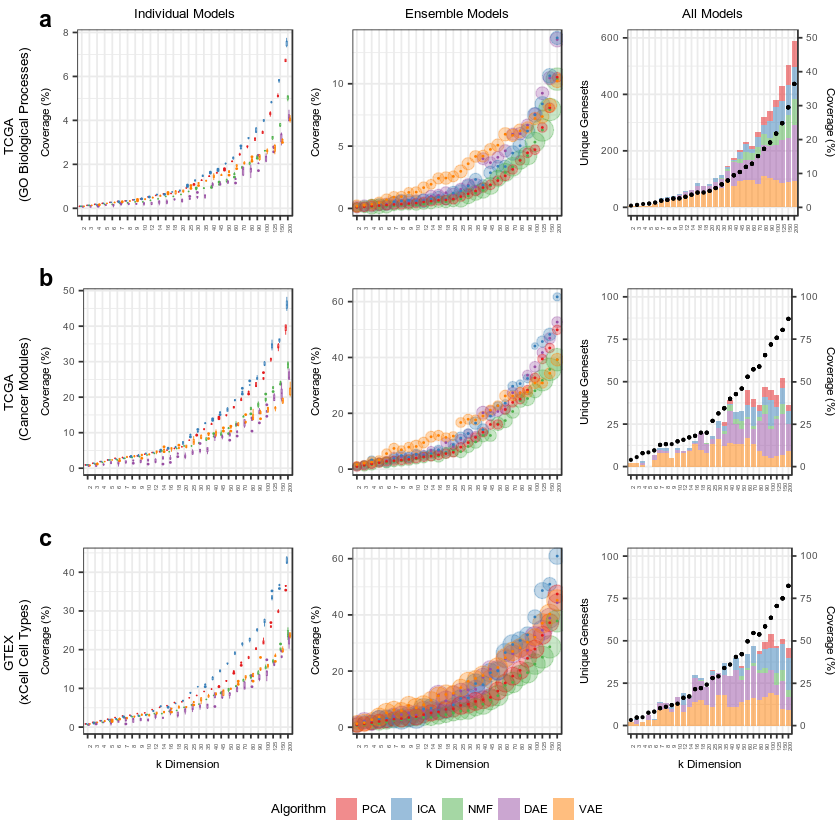

In [5]:
main_plot

In [6]:
for(extension in c('.png', '.pdf')) {
    fig_file <- paste0("coverage", extension)
    fig_file <- file.path("figures", fig_file)
    cowplot::save_plot(filename = fig_file,
                       plot = main_plot,
                       base_height = 150,
                       base_width = 170,
                       units = "mm")
}